<a href="https://colab.research.google.com/github/PRIMEADAWAS/CEB_Assignment/blob/main/CNN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for dectect lung nodule in CT chest

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.random.set_seed(6536115)
tf.__version__, device_lib.list_local_devices()

('2.11.0', [name: "/device:CPU:0"
  device_type: "CPU"
  memory_limit: 268435456
  locality {
  }
  incarnation: 8473136650534300676
  xla_global_id: -1])

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print('Pandas version :',pd.__version__)
print('Numpy version :',np.__version__)
%matplotlib inline

Pandas version : 1.4.4
Numpy version : 1.22.4


In [ ]:
# import os
import cv2
import seaborn as sns
from skimage.io import imread

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Define path to the data directory
url = '/content/drive/MyDrive/Dataset/NoduleNetAssignment/'

## Get trainlabels, vallabels, testlabels list from text file
and separate url and label into list then convert img to 3D integer array store in dataframe

In [ ]:
# Get the path to the normal and cancer sub-directories
url_trainlabels = url + 'trainlabels.txt'
url_vallabels = url + 'vallabels.txt'
url_testlabels = url + 'testlabels.txt'
url_trainlabels, url_vallabels, url_testlabels

('/content/drive/MyDrive/Dataset/NoduleNetAssignment/trainlabels.txt',
 '/content/drive/MyDrive/Dataset/NoduleNetAssignment/vallabels.txt',
 '/content/drive/MyDrive/Dataset/NoduleNetAssignment/testlabels.txt')

In [ ]:
def getDataFromFile(urlLabelText):
  # open file labels.txt
  labels_file = open(urlLabelText,'r')  
  # split all text file by \n and combine to list remove first array "image label" which is not data
  labels_list = labels_file.read().split('\n')[1:]
  # close the file
  labels_file.close()
  # split url and label then store in list
  labels_list = [i.split(' ') for i in labels_list]
  return labels_list

display sample url and label in list

In [ ]:
# use function getDataFromFile to load data from text file and display
trainlabels_list = getDataFromFile(url_trainlabels)
vallabels_list = getDataFromFile(url_vallabels)
testlabels_list = getDataFromFile(url_testlabels)
trainlabels_list[:3], vallabels_list[:3], testlabels_list[:3]

([['train/image_59270.jpg', '0'],
  ['train/image_150277.jpg', '0'],
  ['train/image_432208.jpg', '0']],
 [['val/image_450608.jpg', '0'],
  ['val/image_464772.jpg', '0'],
  ['val/image_298997.jpg', '1']],
 [['test/image_189342.jpg', '0'],
  ['test/image_145102.jpg', '0'],
  ['test/image_31546.jpg', '0']])

## Train data visualization

create pd dataframe for train data to visualization

In [ ]:
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(trainlabels_list, columns=['imgurl', 'label'],index=None)
# concate string original url and image url
train_data['imgurl'] = url + train_data['imgurl']
# convert label column string to int
train_data['label'] = train_data['label'].astype('int')
# How the dataframe looks like?
train_data.head()

,imgurl,label
0,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
1,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
2,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
3,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
4,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0


In [ ]:
train_data.info()
train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5187 entries, 0 to 5186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   imgurl  5187 non-null   object
 1   label   5187 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.2+ KB


(5187, 2)

0    4342
1     845
Name: label, dtype: int64


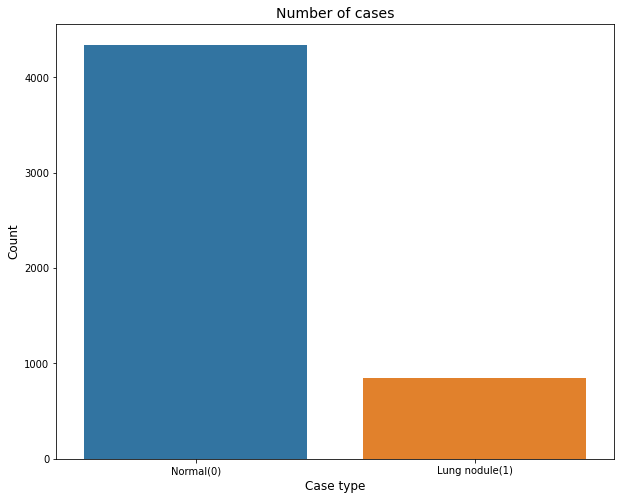

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Lung nodule(1)'])
plt.show()

show 5 sample images of each normal and lung nodule cases.

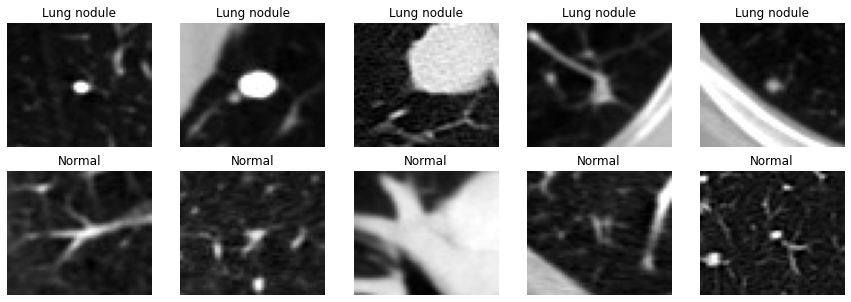

In [ ]:
# Get few samples for both the classes
Tuberculosis_samples = (train_data[train_data['label'] == 1]['imgurl'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label'] == 0]['imgurl'].iloc[:5]).tolist()

# Concat the data in a single list
samples = Tuberculosis_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Lung nodule")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

convert img url into 3D int array and store to column image.

## Image augmentation sample show

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [ ]:
# load image
filepath = train_data['imgurl'][0]
img = load_img(filepath)
# convert image to 3D array
image_data = img_to_array(img)
# convert into 4D of 3D array element
images_data = np.expand_dims(image_data, axis=0)

In [ ]:
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                            #  horizontal_flip=True,
                            #  rotation_range=50,
                             brightness_range=[0.15,2.0],
                             zoom_range=[2,0.5])
# flow create 4D array contain new image augmentation
train_generator = datagen.flow(images_data,batch_size=1)

In [ ]:
def displayImageAugment(generator):
  rows = 5
  columns = 4
  #5 rows x 4 columns plot
  fig, axes = plt.subplots(rows,columns)
  for r in range(rows):
      for c in range(columns):
          #create next image each batch (single image since batch size = 1)
          image_batch = generator.next()
          #convert to unsigned integers for display
          image = image_batch[0].astype('uint8')
          #display image
          axes[r,c].imshow(image)
  #set figure size
  fig.set_size_inches(15,10)

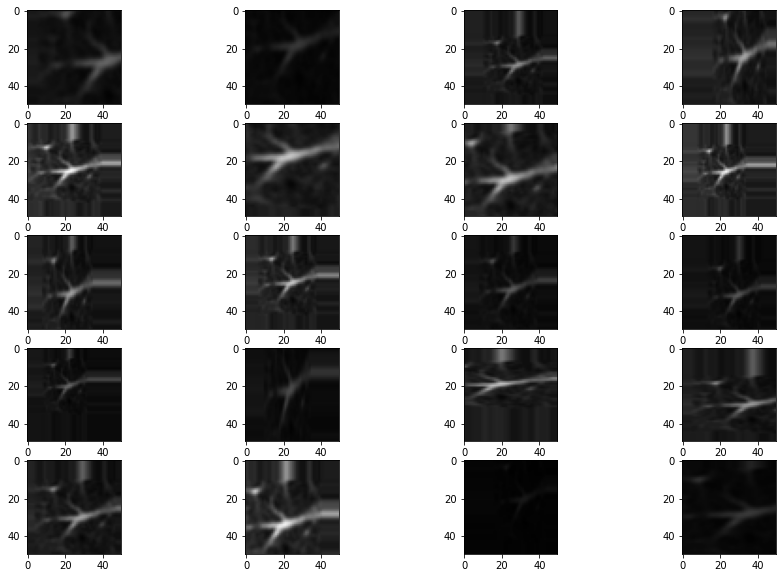

In [ ]:
displayImageAugment(train_generator)

## Convert image file into 3d integer array

In [ ]:
# import tqdm for show progression
from tqdm import tqdm
tqdm.pandas()

In [ ]:
# function for convert image file into 3d integer array and store in list after that return its numpy
def convertImgToIntArray(labels_list):
  datas = []
  labels = []

  for index,data in tqdm(enumerate(labels_list)):
    img = cv2.imread(url+data[0],1)
    img = cv2.resize(img, (50,50))
    if img.shape[2] ==1:
      img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    # img = img/255
    label = int(data[1])
    datas.append(img)
    labels.append(label)
  
  # convert list into numpy array then return data and label
  return np.array(datas), np.array(labels)

In [ ]:
train_data, train_labels  = convertImgToIntArray(trainlabels_list)
train_data[:10], train_labels[1]

print("Total number of train data examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

5187it [51:45,  1.67it/s]

Total number of train data examples:  (5187, 50, 50, 3)
Total number of labels: (5187,)


In [ ]:
vallabels_list
val_data, val_labels = convertImgToIntArray(vallabels_list)
val_data[:10], val_labels[1]

print("Total number of validate data examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

1297it [13:05,  1.65it/s]

Total number of validate data examples:  (1297, 50, 50, 3)
Total number of labels: (1297,)


In [ ]:
testlabels_list
test_data, test_labels = convertImgToIntArray(testlabels_list)
test_data[:10], test_labels[1]

print("Total number of test data examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

1622it [16:02,  1.69it/s]

Total number of test data examples:  (1622, 50, 50, 3)
Total number of labels: (1622,)


In [ ]:
train_data[1], val_data[1], test_data[1]

(array([[[35, 35, 35],
         [18, 18, 18],
         [19, 19, 19],
         ...,
         [20, 20, 20],
         [19, 19, 19],
         [17, 17, 17]],
 
        [[39, 39, 39],
         [22, 22, 22],
         [15, 15, 15],
         ...,
         [30, 30, 30],
         [24, 24, 24],
         [19, 19, 19]],
 
        [[40, 40, 40],
         [28, 28, 28],
         [14, 14, 14],
         ...,
         [50, 50, 50],
         [20, 20, 20],
         [12, 12, 12]],
 
        ...,
 
        [[27, 27, 27],
         [30, 30, 30],
         [37, 37, 37],
         ...,
         [17, 17, 17],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[26, 26, 26],
         [23, 23, 23],
         [26, 26, 26],
         ...,
         [18, 18, 18],
         [16, 16, 16],
         [12, 12, 12]],
 
        [[46, 46, 46],
         [35, 35, 35],
         [27, 27, 27],
         ...,
         [22, 22, 22],
         [17, 17, 17],
         [12, 12, 12]]], dtype=uint8), array([[[ 29,  29,  29],
         [ 22,  2

In [ ]:
X_train = train_data
y_train = train_labels
X_test = test_data
y_test = test_labels
X_val = val_data
y_val = val_labels
X_train.shape

(5187, 50, 50, 3)

## Save preprocess file to h5

In [ ]:
import h5py

In [ ]:
hf = h5py.File(url+'NeuralnetTrain.h5', 'w')
hf.create_dataset('X_train', data=train_data)
hf.create_dataset('y_train', data=train_labels)

<HDF5 dataset "y_train": shape (5187,), type "<i8">

In [ ]:
hf.close()

In [ ]:
hf = h5py.File(url+'NeuralnetVal.h5', 'w')
hf.create_dataset('X_val', data=val_data)
hf.create_dataset('y_val', data=val_labels)

<HDF5 dataset "y_val": shape (1297,), type "<i8">

In [ ]:
hf.close()

In [ ]:
hf = h5py.File(url+'NeuralnetTest.h5', 'w')
hf.create_dataset('X_test', data=test_data)
hf.create_dataset('y_test', data=test_labels)

<HDF5 dataset "y_test": shape (1622,), type "<i8">

In [ ]:
hf.close()

## Read preprocess h5 file

In [ ]:
import h5py

In [ ]:
hf = h5py.File(url+'NeuralnetTrain.h5', 'r')
list(hf.keys())

['X_train', 'y_train']

In [ ]:
print("Loading training data ...", end="")
hf = h5py.File(url + "NeuralnetTrain.h5", "r")
X_train = np.array(hf['X_train'])
y_train = np.array(hf['y_train'])
hf.close()
print(X_train.shape,y_train.shape," Done.")

print("Loading validating data ...", end="")
hf = h5py.File(url + "NeuralnetVal.h5", "r")
X_val = np.array(hf.get("X_val"))
y_val = np.array(hf.get("y_val"))
hf.close()
print(X_val.shape,y_val.shape," Done.")


print("Loading testing data ...", end="")
hf = h5py.File(url + "NeuralnetTest.h5", "r")
X_test = np.array(hf.get("X_test"))
y_test = np.array(hf.get("y_test"))
hf.close()
print(X_test.shape,y_test.shape," Done.")


Loading training data ...(5187, 50, 50, 3) (5187,)  Done.
Loading validating data ...(1297, 50, 50, 3) (1297,)  Done.
Loading testing data ...(1622, 50, 50, 3) (1622,)  Done.


# CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 4, 4, 128)      

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20, verbose = 1)
mc = ModelCheckpoint(filepath = url+'cnnModel2.h5', mode= 'min', verbose = 1, save_best_only=True)

## Image augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.15,2.0],
                             zoom_range=[2,0.5])
datagen.fit(X_train)

calculate class weight

In [ ]:
NO_EPOCHS = 300
BATCH_SIZE = 128
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=NO_EPOCHS, 
                              validation_data=(np.array(X_val), np.array(y_val)),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              callbacks=[es,mc])

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.5829
Epoch 1: val_loss improved from inf to 0.94025, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel2.h5
40/40 [==============================] - 11s 168ms/step - loss: 0.7437 - accuracy: 0.5829 - val_loss: 0.9403 - val_accuracy: 0.8142
Epoch 2/300
40/40 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.7025
Epoch 2: val_loss improved from 0.94025 to 0.60574, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel2.h5
40/40 [==============================] - 8s 177ms/step - loss: 0.5993 - accuracy: 0.7025 - val_loss: 0.6057 - val_accuracy: 0.7147
Epoch 3/300
40/40 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.7689
Epoch 3: val_loss improved from 0.60574 to 0.52993, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel2.h5
40/40 [==============================] - 7s 163ms/step - los

## Model evaluation for CNN with image augmentation

In [ ]:
def plotLoss(modelHistory):
  plt.plot(modelHistory.history['loss'])
  plt.plot(modelHistory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def plotAccuracy(modelHistory):
  plt.plot(modelHistory.history['accuracy'])
  plt.plot(modelHistory.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

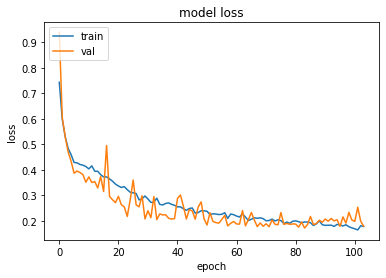

In [ ]:
plotLoss(history)

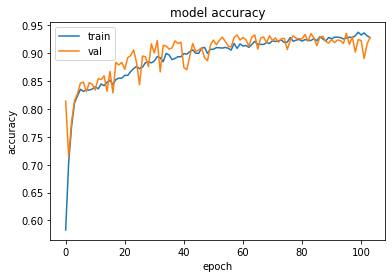

In [ ]:
plotAccuracy(history)

dont run

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

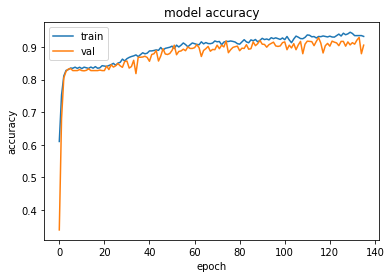

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def plotLossAcc(model):
  fig , ax = plt.subplots(1,2)
  train_acc = model.history['accuracy']
  train_loss = model.history['loss']
  val_acc = model.history['val_accuracy']
  val_loss = model.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

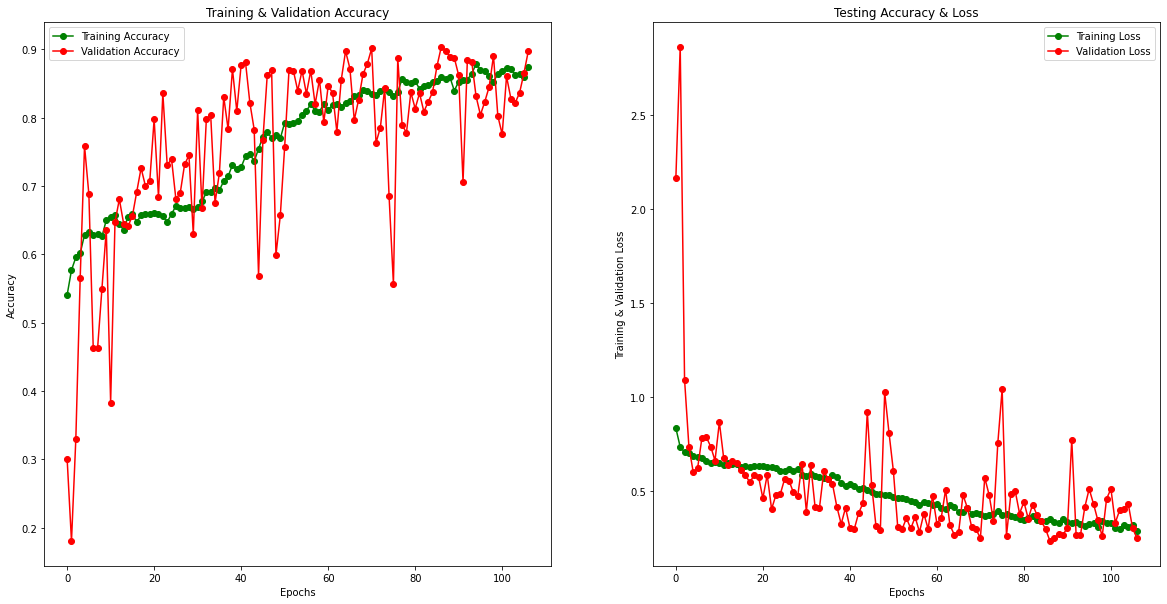

In [ ]:
plotLossAcc(history)

In [ ]:
# compile = False to prevent reset model parameters
cnnModel = models.load_model(url+'cnnModel2.h5', compile = False)

In [ ]:
predictCNN = cnnModel.predict(X_test)
predictCNN

51/51 [==============================] - 0s 3ms/step


array([[0.16875985],
       [0.00118189],
       [0.11169625],
       ...,
       [0.04795174],
       [0.01082491],
       [0.00441203]], dtype=float32)

In [ ]:
def probToClass(prob):
  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=prob, pos_label=1)
  idx = np.argmax(np.abs(tpr - fpr))
  optimal_threshold = thresholds[idx]

  yhat = (prob[:, 0] >= optimal_threshold).astype(int)
  return yhat

In [ ]:
predictClassCNN = probToClass(predictCNN)
predictClassCNN

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.9198520345252774
Recall score is:  0.8936170212765957
F1 score is:  0.7949526813880126
Confusion Matrix: 
       0    1
0  1240  100
1    30  252
                      precision    recall  f1-score   support

    Normal (Class 0)       0.98      0.93      0.95      1340
Lung Nodule(Class 1)       0.72      0.89      0.79       282

            accuracy                           0.92      1622
           macro avg       0.85      0.91      0.87      1622
        weighted avg       0.93      0.92      0.92      1622



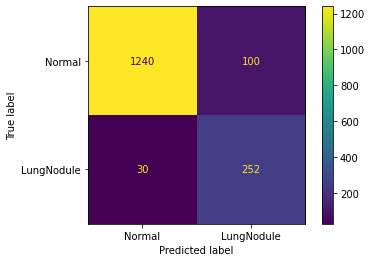

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassCNN))
print("Recall score is: ",recall_score(y_test,predictClassCNN))
print("F1 score is: ",f1_score(y_test,predictClassCNN))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassCNN)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassCNN), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassCNN, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

<Axes: >

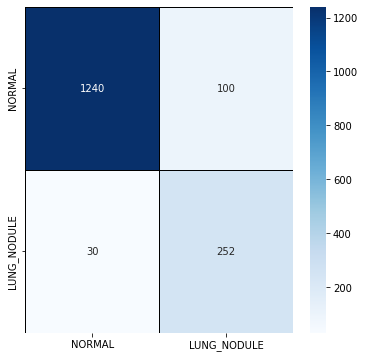

In [ ]:
cm = confusion_matrix(y_test,predictClassCNN)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['NORMAL','LUNG_NODULE']
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

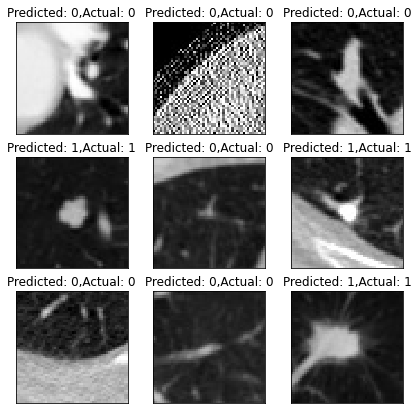

In [ ]:
showTrueAns(predictClassCNN)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

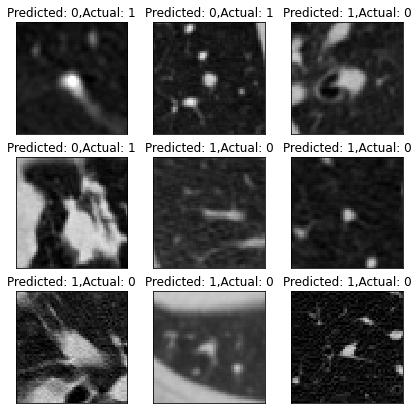

In [ ]:
showFalseAns(predictClassCNN)

# New CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 4, 4, 128)      

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20, verbose = 1)
mc = ModelCheckpoint(filepath = url+'cnnModel.h5', mode= 'min', verbose = 1, save_best_only=True)

## Image augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.15,2.0],
                             zoom_range=[2,0.5])
datagen.fit(X_train)

calculate class weight

In [ ]:
from sklearn.utils import class_weight
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
classWeights = dict(zip(np.unique(y_train), weights))
classWeights

{0: 0.5973053892215568, 1: 3.0692307692307694}

In [ ]:
NO_EPOCHS = 300
BATCH_SIZE = 256
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=NO_EPOCHS, 
                              validation_data=(np.array(X_val), np.array(y_val)),
                              verbose = 1, 
                              # steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              callbacks=[es,mc]
                    # ,         class_weight=classWeights
                              )

# try new class weigth 


Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.7684 - accuracy: 0.5770
Epoch 1: val_loss improved from inf to 2.88661, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel.h5
21/21 [==============================] - 11s 301ms/step - loss: 0.7684 - accuracy: 0.5770 - val_loss: 2.8866 - val_accuracy: 0.2328
Epoch 2/300
21/21 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.6472
Epoch 2: val_loss improved from 2.88661 to 0.56808, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel.h5
21/21 [==============================] - 6s 274ms/step - loss: 0.6546 - accuracy: 0.6472 - val_loss: 0.5681 - val_accuracy: 0.7810
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.7191
Epoch 3: val_loss improved from 0.56808 to 0.52268, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel.h5
21/21 [==============================] - 7s 316ms/step - loss: 

## Model evaluation for CNN with image augmentation

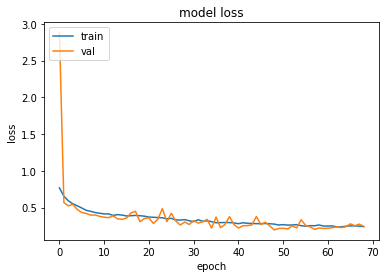

In [ ]:
plotLoss(history)

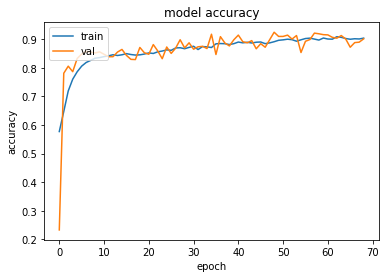

In [ ]:
plotAccuracy(history)

In [ ]:
def plotLossAcc(model):
  fig , ax = plt.subplots(1,2)
  train_acc = model.history['accuracy']
  train_loss = model.history['loss']
  val_acc = model.history['val_accuracy']
  val_loss = model.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

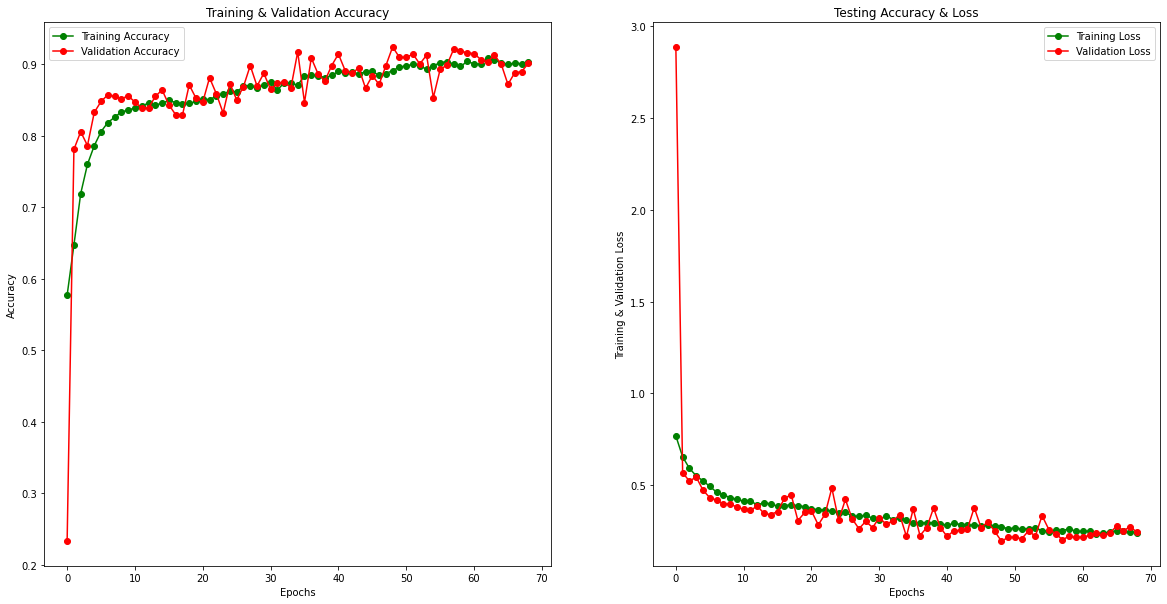

In [ ]:
plotLossAcc(history)

In [ ]:
# compile = False to prevent reset model parameters
cnnModel = models.load_model(url+'cnnModel.h5', compile = False)

In [ ]:
predictCNN = cnnModel.predict_generator(X_test)
predictCNN

51/51 [==============================] - 0s 2ms/step


array([[0.27157977],
       [0.00210683],
       [0.08924015],
       ...,
       [0.13937593],
       [0.0025514 ],
       [0.00190317]], dtype=float32)

In [ ]:
def probToClass(prob):
  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=prob, pos_label=1)
  idx = np.argmax(np.abs(tpr - fpr))
  optimal_threshold = thresholds[idx]

  yhat = (prob[:, 0] >= optimal_threshold).astype(int)
  return yhat

In [ ]:
predictClassCNN = probToClass(predictCNN)
predictClassCNN

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.9075215782983971
Recall score is:  0.8829787234042553
F1 score is:  0.7685185185185185
Confusion Matrix: 
       0    1
0  1223  117
1    33  249
                      precision    recall  f1-score   support

    Normal (Class 0)       0.97      0.91      0.94      1340
Lung Nodule(Class 1)       0.68      0.88      0.77       282

            accuracy                           0.91      1622
           macro avg       0.83      0.90      0.86      1622
        weighted avg       0.92      0.91      0.91      1622



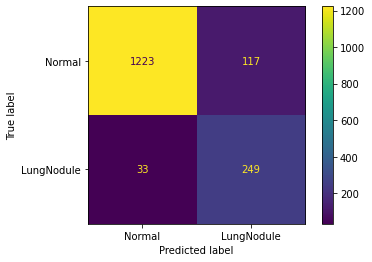

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassCNN))
print("Recall score is: ",recall_score(y_test,predictClassCNN))
print("F1 score is: ",f1_score(y_test,predictClassCNN))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassCNN)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassCNN), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassCNN, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

<Axes: >

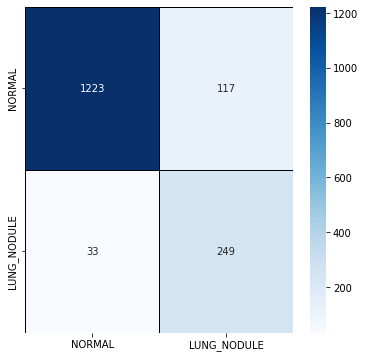

In [ ]:
cm = confusion_matrix(y_test,predictClassCNN)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['NORMAL','LUNG_NODULE']
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

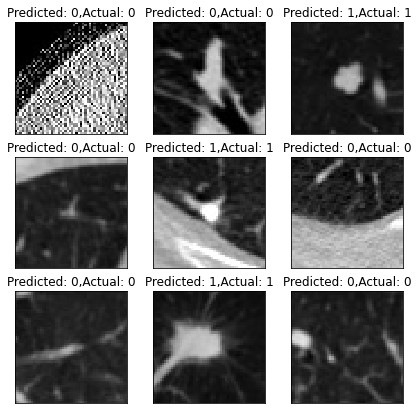

In [ ]:
showTrueAns(predictClassCNN)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

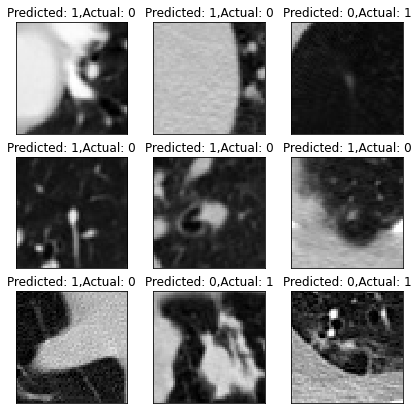

In [ ]:
showFalseAns(predictClassCNN)

# New CNN3 model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 4, 4, 128)      

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20, verbose = 1)
mc = ModelCheckpoint(filepath = url+'cnnModel3.h5', mode= 'min', verbose = 1, save_best_only=True)

## Image augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.15,2.0],
                             zoom_range=[2,0.5])
datagen.fit(X_train)

calculate class weight

In [ ]:
from sklearn.utils import class_weight
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
classWeights = dict(zip(np.unique(y_train), weights))
classWeights

{0: 0.5973053892215568, 1: 3.0692307692307694}

In [ ]:
NO_EPOCHS = 300
BATCH_SIZE = 32
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True),
                              epochs=NO_EPOCHS, 
                              validation_data=(np.array(X_val), np.array(y_val)),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              callbacks=[es,mc]
                    # ,         class_weight=classWeights
                              )



Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.8098 - accuracy: 0.5265
Epoch 1: val_loss improved from inf to 0.94385, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel.h5
21/21 [==============================] - 11s 253ms/step - loss: 0.8098 - accuracy: 0.5265 - val_loss: 0.9439 - val_accuracy: 0.5968
Epoch 2/300
21/21 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.6162
Epoch 2: val_loss improved from 0.94385 to 0.70135, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel.h5
21/21 [==============================] - 7s 327ms/step - loss: 0.6750 - accuracy: 0.6162 - val_loss: 0.7013 - val_accuracy: 0.6631
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.7045
Epoch 3: val_loss improved from 0.70135 to 0.55586, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel.h5
21/21 [==============================] - 5s 256ms/step - loss: 

## Model evaluation for CNN with image augmentation

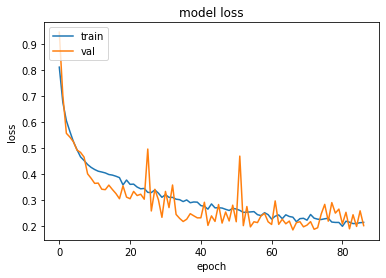

In [ ]:
plotLoss(history)

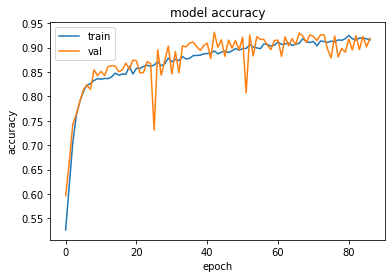

In [ ]:
plotAccuracy(history)

In [ ]:
def plotLossAcc(model):
  fig , ax = plt.subplots(1,2)
  train_acc = model.history['accuracy']
  train_loss = model.history['loss']
  val_acc = model.history['val_accuracy']
  val_loss = model.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

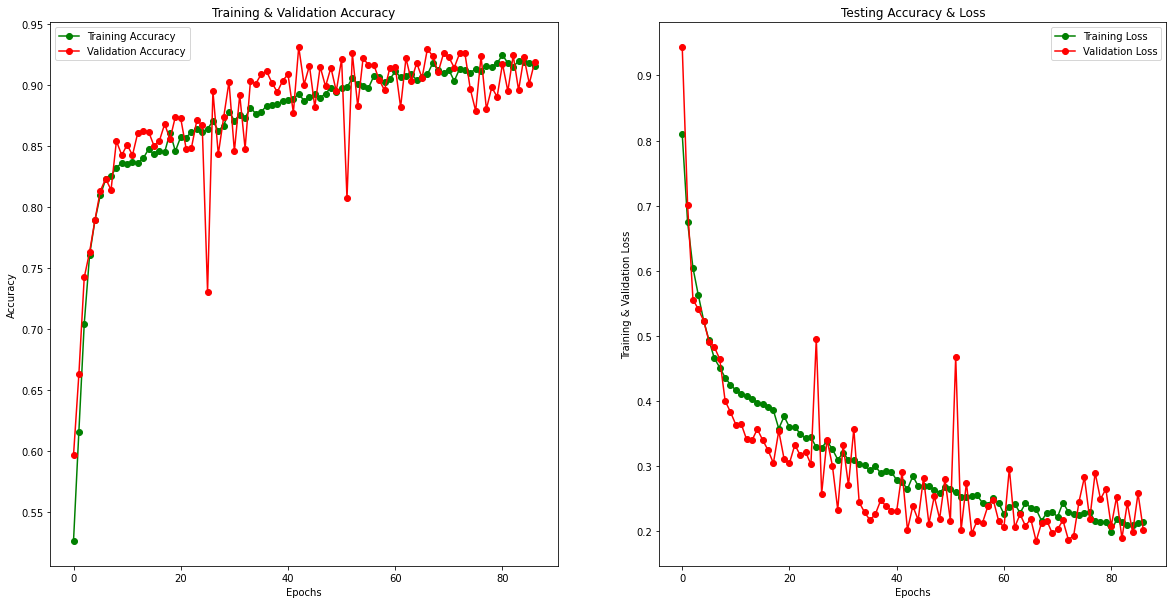

In [ ]:
plotLossAcc(history)

In [ ]:
# compile = False to prevent reset model parameters
cnnModel = models.load_model(url+'cnnModel3.h5', compile = False)

In [ ]:
predictCNN = cnnModel.predict_generator(X_test)
predictCNN

<ipython-input-284-c3369c4a3e0a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictCNN = cnnModel.predict_generator(X_test)


array([[0.13643028],
       [0.02131543],
       [0.173956  ],
       ...,
       [0.08933293],
       [0.02214198],
       [0.01532499]], dtype=float32)

In [ ]:
def probToClass(prob):
  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=prob, pos_label=1)
  idx = np.argmax(np.abs(tpr - fpr))
  optimal_threshold = thresholds[idx]

  yhat = (prob[:, 0] >= optimal_threshold).astype(int)
  return yhat

In [ ]:
predictClassCNN = probToClass(predictCNN)
predictClassCNN

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.9192355117139334
Recall score is:  0.8971631205673759
F1 score is:  0.7943485086342229
Confusion Matrix: 
       0    1
0  1238  102
1    29  253
                      precision    recall  f1-score   support

    Normal (Class 0)       0.98      0.92      0.95      1340
Lung Nodule(Class 1)       0.71      0.90      0.79       282

            accuracy                           0.92      1622
           macro avg       0.84      0.91      0.87      1622
        weighted avg       0.93      0.92      0.92      1622



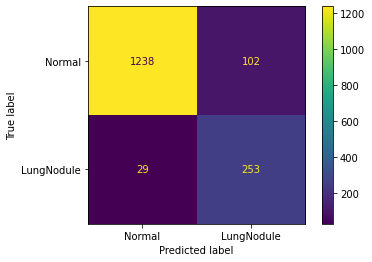

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassCNN))
print("Recall score is: ",recall_score(y_test,predictClassCNN))
print("F1 score is: ",f1_score(y_test,predictClassCNN))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassCNN)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassCNN), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassCNN, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

<Axes: >

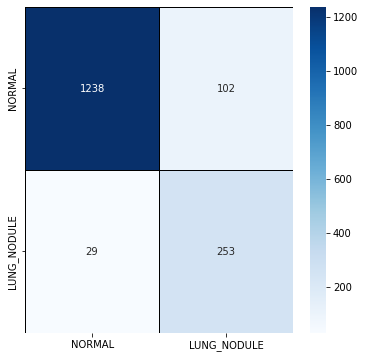

In [ ]:
cm = confusion_matrix(y_test,predictClassCNN)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['NORMAL','LUNG_NODULE']
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

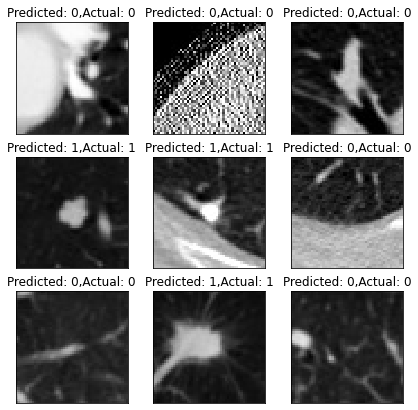

In [ ]:
showTrueAns(predictClassCNN)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

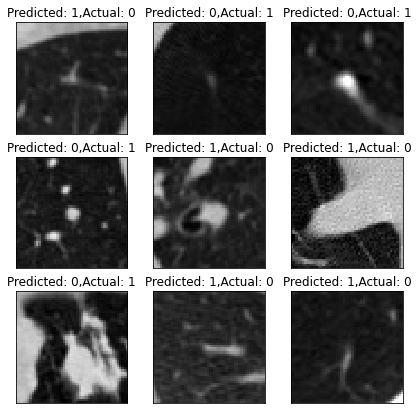

In [ ]:
showFalseAns(predictClassCNN)

# New CNN4 model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 4, 4, 128)      

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20, verbose = 1)
mc = ModelCheckpoint(filepath = url+'cnnModel4.h5', mode= 'min', verbose = 1, save_best_only=True)

## Image augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
trainDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.15,2.0],
                                  zoom_range=[2,0.5])
trainDatagen.fit(X_train)

In [ ]:
# create image data augmentation generator
valDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.15,2.0],
                                  zoom_range=[2,0.5])
valDatagen.fit(X_val)

In [ ]:
# create image data augmentation generator
testDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.15,2.0],
                                  zoom_range=[2,0.5])
test_datagen=trainDatagen.flow(X_val, y_val, batch_size=8, shuffle=True)

calculate class weight

In [ ]:
NO_EPOCHS = 300
BATCH_SIZE = 32
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              validation_data=trainDatagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
                              validation_steps=X_val.shape[0] // BATCH_SIZE,
                              epochs=NO_EPOCHS, 
                              verbose = 1, 
                              callbacks=[es,mc])

# remove datagen fit
# decrease model parameter

Epoch 1/300


<ipython-input-160-66bd36702134>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),


161/162 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.6933
Epoch 1: val_loss improved from inf to 0.47855, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel4.h5
162/162 [==============================] - 18s 82ms/step - loss: 0.6100 - accuracy: 0.6943 - val_loss: 0.4785 - val_accuracy: 0.8273
Epoch 2/300
162/162 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.8200
Epoch 2: val_loss improved from 0.47855 to 0.43374, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel4.h5
162/162 [==============================] - 10s 62ms/step - loss: 0.4673 - accuracy: 0.8200 - val_loss: 0.4337 - val_accuracy: 0.8297
Epoch 3/300
161/162 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8341
Epoch 3: val_loss did not improve from 0.43374
162/162 [==============================] - 9s 58ms/step - loss: 0.4370 - accuracy: 0.8345 - val_loss: 0.4434 - val_accuracy: 0.8258
Epoch 4/300
161/

## Model evaluation for CNN with image augmentation

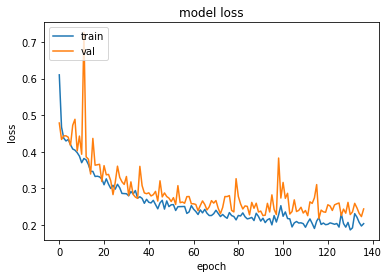

In [ ]:
plotLoss(history)

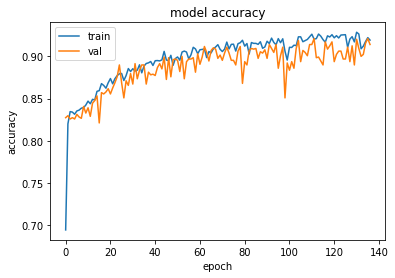

In [ ]:
plotAccuracy(history)

In [ ]:
def plotLossAcc(model):
  fig , ax = plt.subplots(1,2)
  train_acc = model.history['accuracy']
  train_loss = model.history['loss']
  val_acc = model.history['val_accuracy']
  val_loss = model.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

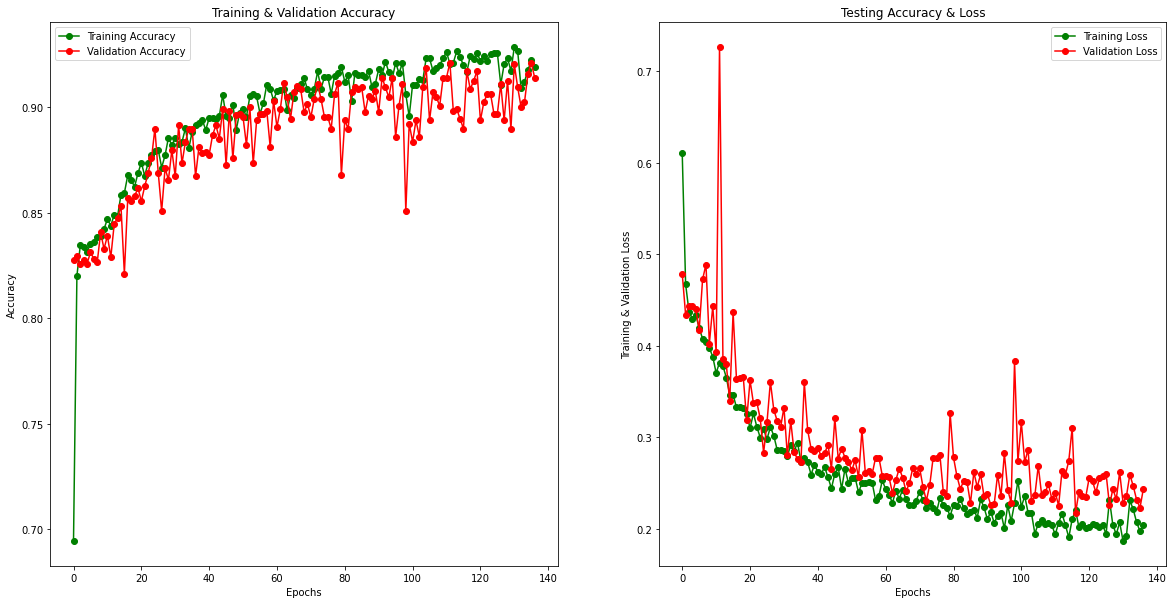

In [ ]:
plotLossAcc(history)

In [ ]:
# compile = False to prevent reset model parameters
cnnModel = models.load_model(url+'cnnModel4.h5', compile = False)

In [ ]:
predictCNN = cnnModel.predict_generator(X_test)
predictCNN

<ipython-input-28-c3369c4a3e0a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictCNN = cnnModel.predict_generator(X_test)


array([[1.0000000e+00],
       [1.0000000e+00],
       [7.3754203e-09],
       ...,
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [ ]:
def probToClass(prob):
  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=prob, pos_label=1)
  idx = np.argmax(np.abs(tpr - fpr))
  optimal_threshold = thresholds[idx]

  yhat = (prob[:, 0] >= optimal_threshold).astype(int)
  return yhat

In [ ]:
predictClassCNN = probToClass(predictCNN)
predictClassCNN

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.8921085080147966
Recall score is:  0.8829787234042553
F1 score is:  0.7399702823179791
Confusion Matrix: 
       0    1
0  1198  142
1    33  249
                      precision    recall  f1-score   support

    Normal (Class 0)       0.97      0.89      0.93      1340
Lung Nodule(Class 1)       0.64      0.88      0.74       282

            accuracy                           0.89      1622
           macro avg       0.81      0.89      0.84      1622
        weighted avg       0.91      0.89      0.90      1622



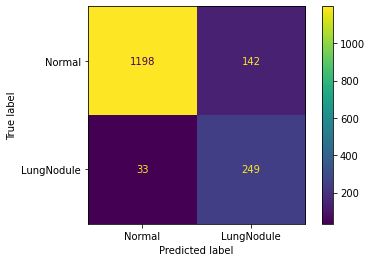

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassCNN))
print("Recall score is: ",recall_score(y_test,predictClassCNN))
print("F1 score is: ",f1_score(y_test,predictClassCNN))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassCNN)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassCNN), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassCNN, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

<Axes: >

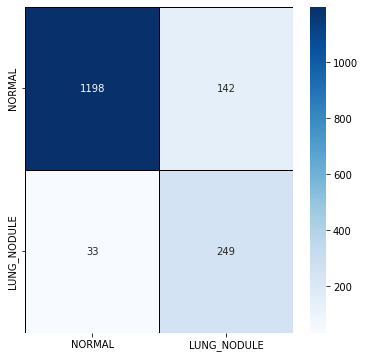

In [ ]:
cm = confusion_matrix(y_test,predictClassCNN)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['NORMAL','LUNG_NODULE']
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

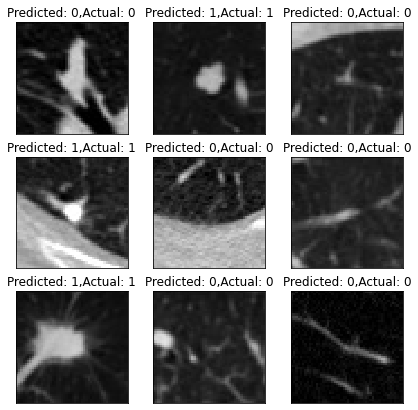

In [ ]:
showTrueAns(predictClassCNN)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

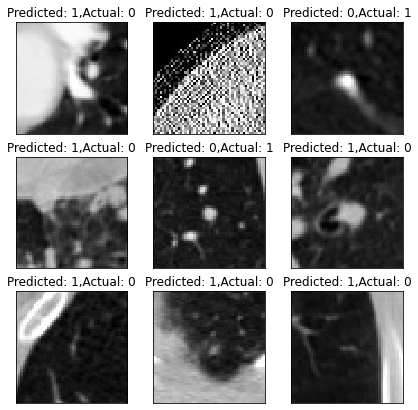

In [ ]:
showFalseAns(predictClassCNN)

# New CNN5 model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                                 
                                                      

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20, verbose = 1)
mc = ModelCheckpoint(filepath = url+'cnnModel4.h5', mode= 'min', verbose = 1, save_best_only=True)

## Image augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
trainDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.15,2.0],
                                  zoom_range=[2,0.5])
trainDatagen.fit(X_train)

In [ ]:
# create image data augmentation generator
valDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.15,2.0],
                                  zoom_range=[2,0.5])
valDatagen.fit(X_val)

In [ ]:
# create image data augmentation generator
testDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.15,2.0],
                                  zoom_range=[2,0.5])
test_datagen=testDatagen.flow(X_test, y_test, batch_size=32, shuffle=True)

calculate class weight

In [ ]:
NO_EPOCHS = 300
BATCH_SIZE = 32
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              validation_data=trainDatagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
                              validation_steps=X_val.shape[0] // BATCH_SIZE,
                              epochs=NO_EPOCHS, 
                              verbose = 1, 
                              callbacks=[es,mc])

# remove datagen fit
# decrease model parameter

Epoch 1/300


<ipython-input-160-66bd36702134>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),


161/162 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.6933
Epoch 1: val_loss improved from inf to 0.47855, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel4.h5
162/162 [==============================] - 18s 82ms/step - loss: 0.6100 - accuracy: 0.6943 - val_loss: 0.4785 - val_accuracy: 0.8273
Epoch 2/300
162/162 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.8200
Epoch 2: val_loss improved from 0.47855 to 0.43374, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel4.h5
162/162 [==============================] - 10s 62ms/step - loss: 0.4673 - accuracy: 0.8200 - val_loss: 0.4337 - val_accuracy: 0.8297
Epoch 3/300
161/162 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8341
Epoch 3: val_loss did not improve from 0.43374
162/162 [==============================] - 9s 58ms/step - loss: 0.4370 - accuracy: 0.8345 - val_loss: 0.4434 - val_accuracy: 0.8258
Epoch 4/300
161/

## Model evaluation for CNN with image augmentation

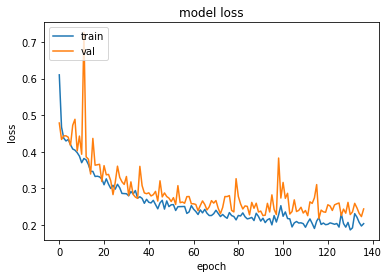

In [ ]:
plotLoss(history)

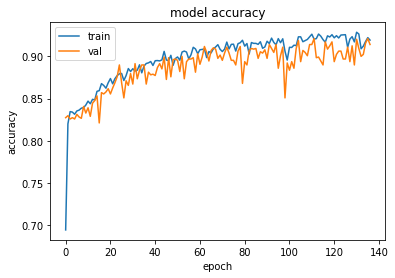

In [ ]:
plotAccuracy(history)

In [ ]:
def plotLossAcc(model):
  fig , ax = plt.subplots(1,2)
  train_acc = model.history['accuracy']
  train_loss = model.history['loss']
  val_acc = model.history['val_accuracy']
  val_loss = model.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

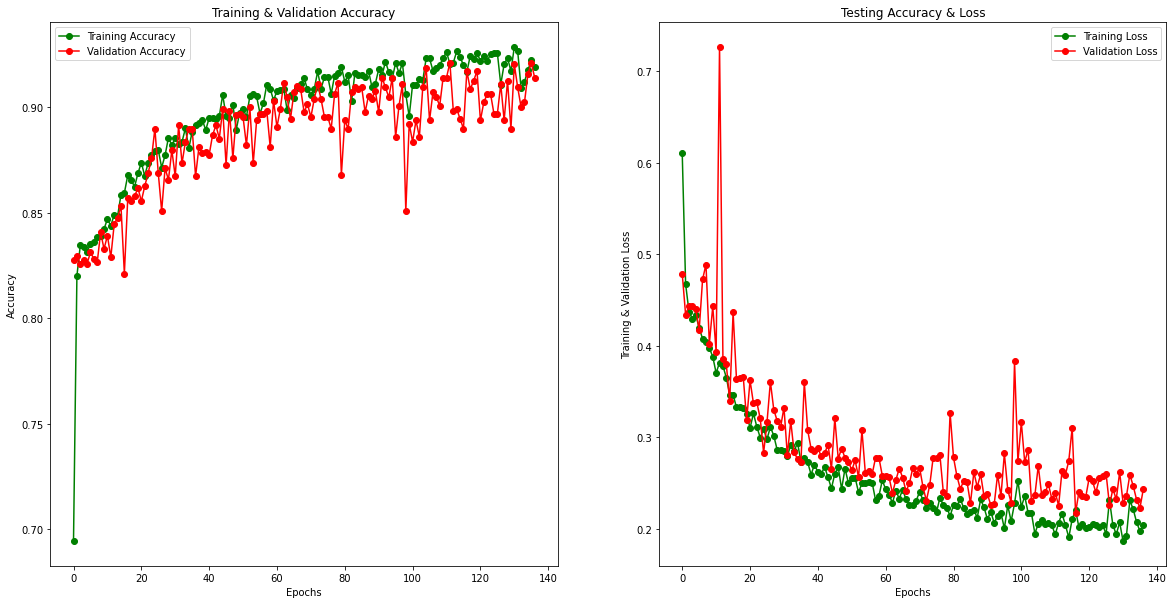

In [ ]:
plotLossAcc(history)

In [ ]:
# compile = False to prevent reset model parameters
cnnModel = models.load_model(url+'cnnModel4.h5', compile = False)

In [ ]:
# create image data augmentation generator
testDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.15,2.0],
                                  zoom_range=[2,0.5])
test_datagen=testDatagen.flow(X_test, y_test, batch_size=32, shuffle=True)
test_datagen

In [ ]:
x_train, y_train = test_datagen

ValueError: ignored

In [ ]:
predictCNN = cnnModel.predict_generator(test_datagen)
predictCNN

<ipython-input-90-6a56596aae05>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictCNN = cnnModel.predict_generator(test_datagen)


array([[0.01379202],
       [0.98153746],
       [0.03797991],
       ...,
       [0.03789376],
       [0.06130713],
       [0.01268193]], dtype=float32)

In [ ]:
predictCNN.shape

(1622, 1)

In [ ]:
from sklearn.metrics import roc_curve
def probToClass(datagen):
  y_predict = cnnModel.predict_generator(datagen)
  fpr, tpr, thresholds = roc_curve(y_true=datagen, y_score=y_predict, pos_label=1)
  idx = np.argmax(np.abs(tpr - fpr))
  optimal_threshold = thresholds[idx]

  yhat = (y_predict[:, 0] >= optimal_threshold).astype(int)
  return yhat

In [ ]:
predictClassCNN = probToClass(test_datagen)
predictClassCNN

<ipython-input-97-439dbd8f5548>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_predict = cnnModel.predict_generator(datagen)


ValueError: ignored

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.3625154130702836
Recall score is:  0.5957446808510638
F1 score is:  0.24525547445255474
Confusion Matrix: 
      0    1
0  420  920
1  114  168
                      precision    recall  f1-score   support

    Normal (Class 0)       0.79      0.31      0.45      1340
Lung Nodule(Class 1)       0.15      0.60      0.25       282

            accuracy                           0.36      1622
           macro avg       0.47      0.45      0.35      1622
        weighted avg       0.68      0.36      0.41      1622



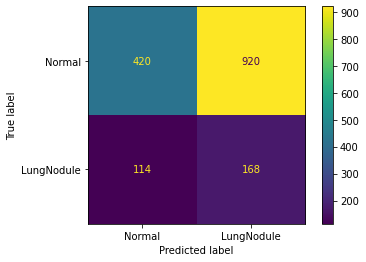

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassCNN))
print("Recall score is: ",recall_score(y_test,predictClassCNN))
print("F1 score is: ",f1_score(y_test,predictClassCNN))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassCNN)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassCNN), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassCNN, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

<Axes: >

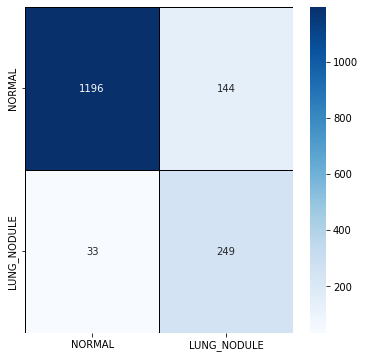

In [ ]:
cm = confusion_matrix(y_test,predictClassCNN)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['NORMAL','LUNG_NODULE']
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

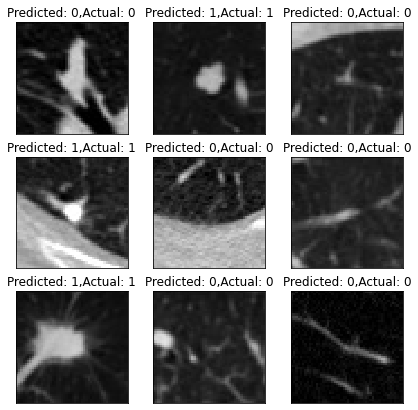

In [ ]:
showTrueAns(predictClassCNN)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

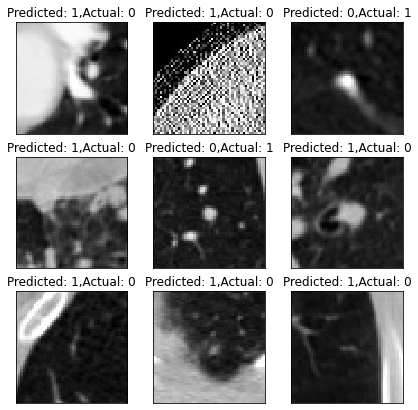

In [ ]:
showFalseAns(predictClassCNN)

# VGG

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

see vgg16 model first

In [ ]:
pretrain = VGG16(weights='imagenet', 
                 include_top = True)
for l in pretrain.layers:
  print(l.name, l.trainable,l)

553467096/553467096 [==============================] - 3s 0us/step
input_1 True <keras.engine.input_layer.InputLayer object at 0x7f54b687ca30>
block1_conv1 True <keras.layers.convolutional.conv2d.Conv2D object at 0x7f5566a9dbb0>
block1_conv2 True <keras.layers.convolutional.conv2d.Conv2D object at 0x7f54b678e4f0>
block1_pool True <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f54b675f460>
block2_conv1 True <keras.layers.convolutional.conv2d.Conv2D object at 0x7f54b678eca0>
block2_conv2 True <keras.layers.convolutional.conv2d.Conv2D object at 0x7f54b671cb20>
block2_pool True <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f54b6720df0>
block3_conv1 True <keras.layers.convolutional.conv2d.Conv2D object at 0x7f54b6724940>
block3_conv2 True <keras.layers.convolutional.conv2d.Conv2D object at 0x7f54b6724be0>
block3_conv3 True <keras.layers.convolutional.conv2d.Conv2D object at 0x7f54b67204c0>
block3_pool True <keras.layers.pooling.max_pooling2d.MaxPooling2D objec

ajarn model

In [ ]:
height = 50
width = 50
depth = 3
# create tensor input from image shape
input_tensor = Input(shape=(height,width,depth))

# import vgg16 model wihout top layer(flatten and dense)
pretrain = VGG16(weights='imagenet', 
                 include_top = False, 
                 input_tensor=input_tensor)

for layer in pretrain.layers:
  layer.trainable = False # freeze all layers

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# to use tranfer learning create own flatten, dense and sigmoid to combine with vgg16 without top layers
model = Sequential()
model.add(pretrain)
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_24 (Flatten)        (None, 512)               0         
                                                                 
 dense_92 (Dense)            (None, 128)               65664     
                                                                 
 batch_normalization_72 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_52 (Dropout)        (None, 128)               0         
                                                                 
 dense_93 (Dense)            (None, 64)                8256      
                                                     

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20, verbose = 1)

mc = ModelCheckpoint(filepath = url+'vgg16Model.h5', mode= 'min', verbose = 1, save_best_only=True)

In [ ]:
# history = model.fit(x=X_train,
#                     y=y_train,
#                     epochs=100,
#                     validation_data=(X_val, y_val),
#                     callbacks=[es, mc]
#                     )
NO_EPOCHS = 300
BATCH_SIZE = 32
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True),
                              epochs=NO_EPOCHS, 
                              validation_data=(np.array(X_val), np.array(y_val)),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              callbacks=[es,mc])

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.6298
Epoch 1: val_loss improved from inf to 0.43926, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vgg16Model.h5
40/40 [==============================] - 11s 256ms/step - loss: 0.6685 - accuracy: 0.6298 - val_loss: 0.4393 - val_accuracy: 0.8311
Epoch 2/300
40/40 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.7306
Epoch 2: val_loss improved from 0.43926 to 0.40359, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vgg16Model.h5
40/40 [==============================] - 7s 173ms/step - loss: 0.5634 - accuracy: 0.7306 - val_loss: 0.4036 - val_accuracy: 0.8358
Epoch 3/300
40/40 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.7859
Epoch 3: val_loss improved from 0.40359 to 0.37880, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vgg16Model.h5
40/40 [==============================] - 6s 161ms/step - 

## Model evaluation

plot accuracy and loss score

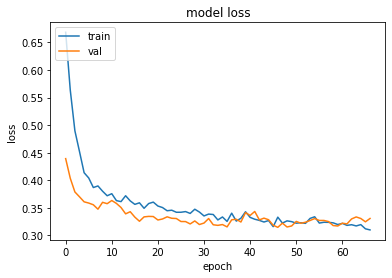

In [ ]:
plotLoss(history)

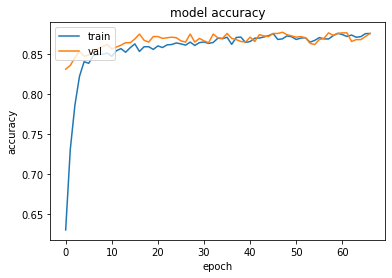

In [ ]:
plotAccuracy(history)

In [ ]:
def plotLossAcc(model):
  fig , ax = plt.subplots(1,2)
  train_acc = model.history['accuracy']
  train_loss = model.history['loss']
  val_acc = model.history['val_accuracy']
  val_loss = model.history['val_loss']
  fig.set_size_inches(20,10)

  ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

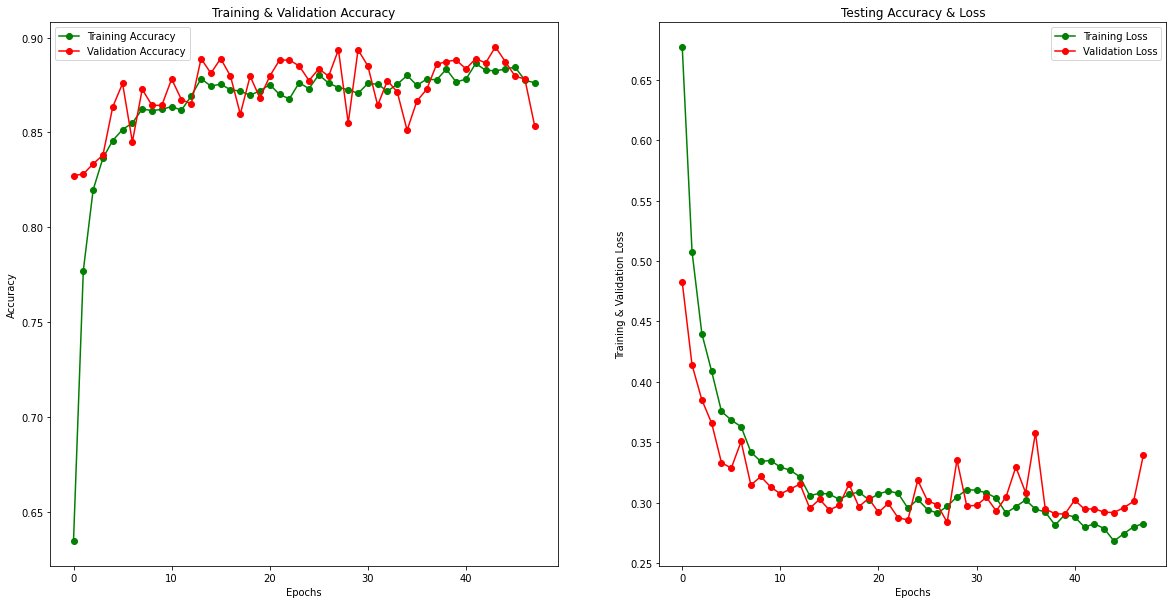

In [ ]:
plotLossAcc(history)

## load Model 

In [ ]:
mymodel = load_model(url + 'vgg16Model.h5', compile = False)
# compile prevent reset model

In [ ]:
predict = mymodel.predict(X_test)
predict

51/51 [==============================] - 1s 18ms/step


array([[0.11890229],
       [0.18941046],
       [0.08733396],
       ...,
       [0.22793387],
       [0.0165955 ],
       [0.01069744]], dtype=float32)

In [ ]:
def probToClass(prob):
  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=predict, pos_label=1)
  idx = np.argmax(np.abs(tpr - fpr))
  optimal_threshold = thresholds[idx]

  yhat = (prob[:, 0] >= optimal_threshold).astype(int)
  return np.array(yhat)

In [ ]:
predictClass = probToClass(predict)
predictClass, y_test

(array([1, 1, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.7583230579531443
Recall score is:  0.8226950354609929
F1 score is:  0.5420560747663551
Confusion Matrix: 
      0    1
0  998  342
1   50  232
                      precision    recall  f1-score   support

    Normal (Class 0)       0.95      0.74      0.84      1340
Lung Nodule(Class 1)       0.40      0.82      0.54       282

            accuracy                           0.76      1622
           macro avg       0.68      0.78      0.69      1622
        weighted avg       0.86      0.76      0.78      1622



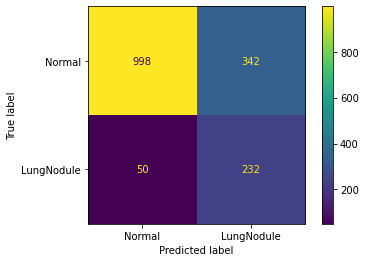

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClass))
print("Recall score is: ",recall_score(y_test,predictClass))
print("F1 score is: ",f1_score(y_test,predictClass))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClass)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClass), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClass, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

<Axes: >

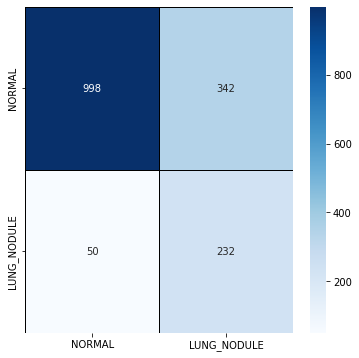

In [ ]:
cm = confusion_matrix(y_test,predictClass)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
labels = ['NORMAL', 'LUNG_NODULE']
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

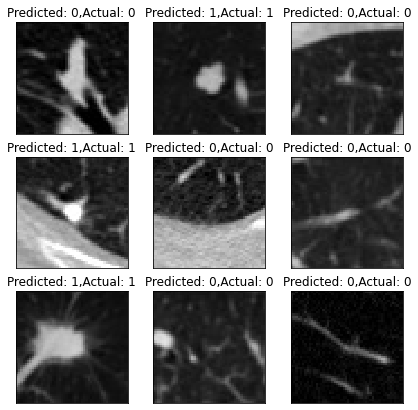

In [ ]:
showTrueAns(predictClass)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

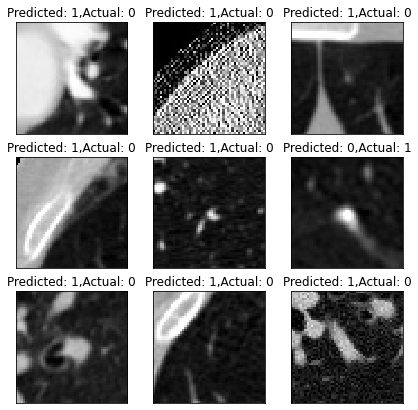

In [ ]:
showFalseAns(predictClass)

# unuse

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)) ,
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu')
    
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
Total params: 93,248
Trainable params: 93,248
Non-tra

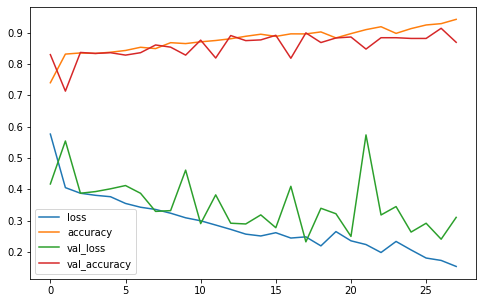

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
n1 = hf.get('X_train')
n1 = np.array(n1)
n1[:5]

In [ ]:
# open file trainlabels.txt
trainlabels_file = open(url_trainlabels,'r')  
# split all text file and combine to list remove first array "image label" which is not data
trainlabels_list = trainlabels_file.read().split('\n')[1:]
trainlabels_file.close()
trainlabels_list[:10]

['train/image_59270.jpg 0',
 'train/image_150277.jpg 0',
 'train/image_432208.jpg 0',
 'train/image_423122.jpg 0',
 'train/image_344581.jpg 0',
 'train/image_75111.jpg 0',
 'train/image_246217.jpg 0',
 'train/image_292479.jpg 0',
 'train/image_147683.jpg 1',
 'train/image_468235.jpg 1']

In [ ]:
# split url and label then store in list
trainlabels_list[0].split(' ')

['train/image_59270.jpg', '0']

In [ ]:
trainlabels_list = [i.split(' ') for i in trainlabels_list]
trainlabels_list[:10]

[['train/image_59270.jpg', '0'],
 ['train/image_150277.jpg', '0'],
 ['train/image_432208.jpg', '0'],
 ['train/image_423122.jpg', '0'],
 ['train/image_344581.jpg', '0'],
 ['train/image_75111.jpg', '0'],
 ['train/image_246217.jpg', '0'],
 ['train/image_292479.jpg', '0'],
 ['train/image_147683.jpg', '1'],
 ['train/image_468235.jpg', '1']]

3
(50, 50, 3)
<class 'int'> <class 'numpy.ndarray'>
[[[12 12 12]
  [ 9  9  9]
  [ 8  8  8]
  ...
  [22 22 22]
  [26 26 26]
  [32 32 32]]

 [[10 10 10]
  [13 13 13]
  [17 17 17]
  ...
  [18 18 18]
  [26 26 26]
  [31 31 31]]

 [[13 13 13]
  [16 16 16]
  [19 19 19]
  ...
  [20 20 20]
  [26 26 26]
  [31 31 31]]

 ...

 [[23 23 23]
  [20 20 20]
  [18 18 18]
  ...
  [22 22 22]
  [24 24 24]
  [24 24 24]]

 [[20 20 20]
  [23 23 23]
  [19 19 19]
  ...
  [21 21 21]
  [26 26 26]
  [35 35 35]]

 [[22 22 22]
  [25 25 25]
  [27 27 27]
  ...
  [17 17 17]
  [23 23 23]
  [32 32 32]]]


array([[[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       ...,

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[22, 22, 22],
        [22, 22, 22],
        [22, 22, 22],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]]], dtype=uint8)

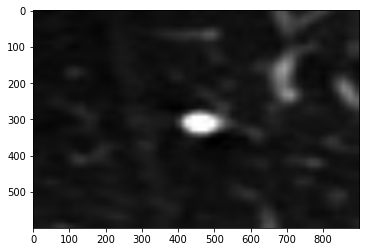

In [ ]:
# 1 color, 0 grayscale
img = cv2.imread(samples[0], 1)
img

# read img
print(img.ndim)
print(img.shape)
print(type(img.ndim),type(img))
print(img)

# img resize
height = 900
width = 600
imgresize = cv2.resize(img, (height, width))

# show img
plt.imshow(imgresize)
imgresize

In [ ]:
train_data = []
train_labels = []

for index,data in tqdm(enumerate(trainlabels_list)):
  # if(index < 10):
    img = cv2.imread(url+data[0],1)
    img = cv2.resize(img, (50,50))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    # img = img/255
    label = int(data[1])
    train_data.append(img)
    train_labels.append(label)
# trainlabels_list
train_labels[:10], train_data[1]

5187it [00:08, 597.96it/s]


([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], array([[[35, 35, 35],
         [18, 18, 18],
         [19, 19, 19],
         ...,
         [20, 20, 20],
         [19, 19, 19],
         [17, 17, 17]],
 
        [[39, 39, 39],
         [22, 22, 22],
         [15, 15, 15],
         ...,
         [30, 30, 30],
         [24, 24, 24],
         [19, 19, 19]],
 
        [[40, 40, 40],
         [28, 28, 28],
         [14, 14, 14],
         ...,
         [50, 50, 50],
         [20, 20, 20],
         [12, 12, 12]],
 
        ...,
 
        [[27, 27, 27],
         [30, 30, 30],
         [37, 37, 37],
         ...,
         [17, 17, 17],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[26, 26, 26],
         [23, 23, 23],
         [26, 26, 26],
         ...,
         [18, 18, 18],
         [16, 16, 16],
         [12, 12, 12]],
 
        [[46, 46, 46],
         [35, 35, 35],
         [27, 27, 27],
         ...,
         [22, 22, 22],
         [17, 17, 17],
         [12, 12, 12]]], dtype=uint8))

In [ ]:
# Convert the list into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print("Total number of train data examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of train data examples:  (5187, 50, 50, 3)
Total number of labels: (5187,)


In [ ]:
train_data.shape

(5187, 50, 50, 3)

In [ ]:
def plotLossAcc(model):
  plt.figure(figsize = (6,6))
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'val loss'], loc='upper left')
  plt.show()

  plt.figure(figsize = (6,6))
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
  plt.show()

In [ ]:
# for softmax
predictClassCNN = np.argmax(predictCNN, axis=1)
predictClassCNN

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# cal class weight from scratch
df = pd.DataFrame(y_train)
weights = np.array(df.value_counts())
weight_for_0 = (1 / weights[0]) * (np.sum(weights) / 2.0)
weight_for_1 = (1 / weights[1]) * (np.sum(weights) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.5973053892215568, 1: 3.0692307692307694}

## failure

In [ ]:
def convertToIntArray(url):
  img = cv2.imread(str(url),1)
  # img resize
  # height = 50
  # width = 50
  # img = cv2.resize(img, (height, width))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img=np.array(img).astype('float32')
  # img = img/255
  return img

In [ ]:
url = train_data['imgurl'].iloc[0]
convertToIntArray(url)

IndexError: ignored

In [ ]:
# df['labels'] = df['bmi'].progress_apply(lambda x: bmicheck(x))
# df
# train_data['image'] = cv2.imread(train_data['image'],1)
train_data['image'] = train_data['imgurl'].progress_apply(convertToIntArray)
# img = cv2.imread(train_data['image'],1)
# img
# train_data['image'].iloc[5] = cv2.imread(train_data['image'].iloc[5],1)
train_data

In [ ]:
train_data.info()
train_data.shape

In [ ]:
url = '/content/drive/MyDrive/Dataset/NoduleNetAssignment/'
train_data.to_csv(url+'train_dataRGBNormalize.csv',
          sep='|',
          index=False,
          encoding='utf-8')

In [ ]:
train_data.to_hdf(url+'train_dataRGBNormalize.h5', key='df', mode='w')

In [ ]:
df = pd.read_hdf(url+'train_dataRGBNormalize.h5', 'df')
df

In [ ]:
df.info()

In [ ]:
dfimage = []
for img in df['image']:
  dfimage.append(img)

dfimage = np.array(dfimage)

print("Total number of validation examples: ", dfimage.shape)

In [ ]:
# numeric_list = df.select_dtypes(include=[np.number]).columns
# df[numeric_list] = df[numeric_list].astype(np.float32)

In [ ]:
X_train = df['image'].iloc[:4000].to_numpy()
y_train = df['label'].iloc[:4000].to_numpy()
X_test = df['image'].iloc[4000:].to_numpy()
y_test = df['label'].iloc[4000:].to_numpy()
# X_train = X_train.to_numpy()
X_train = np.array(X_train) / 255
# resize data for deep learning 
type(X_train)
# X_train=np.asarray(X_train).astype(np.int)
# y_train=np.asarray(y_train).astype(np.int)
# tf.convert_to_tensor(X_train, dtype=tf.float32)
# tf.convert_to_tensor(y_train, dtype=tf.float32)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(50,
                                  50,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
   
  #  crop
  #  brightness
  #  rotate
      
  ]
)

# buttom